In [6]:
import sqlite3
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

In [7]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
df_train.dropna(inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5080 entries, 31 to 7581
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5080 non-null   int64 
 1   keyword   5080 non-null   object
 2   location  5080 non-null   object
 3   text      5080 non-null   object
 4   target    5080 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 238.1+ KB


fine_tuned_model = SentenceTransformer('avsolatorio/GIST-small-Embedding-v0')

text_embeddings = []
for text in tqdm(df_train['text'].tolist(), total=len(df_train)):
    text_embeddings.append(fine_tuned_model.encode(text, convert_to_tensor=False))


df_train['text_embeddings'] = text_embeddings
print(df_train.info())

# Connect to the SQLite database
conn = sqlite3.connect('df_train_gist.db')
cursor = conn.cursor()

# Create the table with the specified columns
cursor.execute('''
    CREATE TABLE IF NOT EXISTS embeddings (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        keyword TEXT,
        location TEXT,
        text TEXT,
        target INTEGER,
        text_embeddings BLOB
    )
''')

conn.commit()

# Insert data into the table
for idx, (keyword, location, text, target, text_emb) in enumerate(zip(df_train['keyword'], df_train['location'], df_train['text'], df_train['target'], text_embeddings)):
    text_emb_np = text_emb
    cursor.execute('''
        INSERT INTO embeddings (keyword, location, text, target, text_embeddings)
        VALUES (?, ?, ?, ?, ?)
    ''', (keyword, location, text, target, text_emb_np.tobytes()))

conn.commit()
conn.close()

In [12]:
# Load the embeddings from the vector database
def load_embeddings(db_path):
    conn = sqlite3.connect(db_path)
    
    query = 'SELECT * FROM embeddings'
    result = conn.execute(query).fetchall()
    
    columns = ['id', 'keyword', 'location', 'text', 'target', 'text_embeddings']
    df = pd.DataFrame(result, columns=columns)
    
    df['text_embeddings'] = df['text_embeddings'].apply(lambda x: np.frombuffer(x, dtype=np.float32))
    
    conn.close()
    
    return df

# Usage
db_path = 'df_train_gist.db'
training_df = load_embeddings(db_path)
training_df.head()

,id,keyword,location,text,target,text_embeddings
0,1,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,"[0.003584282, -0.025532365, 0.02570604, 0.0022..."
1,2,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,"[-0.04236231, -0.0032319976, 0.041993283, -0.0..."
2,3,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,"[-0.03305286, 0.063531056, 0.020465327, 0.0123..."
3,4,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,"[-0.025947293, 0.00052333093, 0.033906557, -0...."
4,5,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,"[-0.028906683, 0.03791683, -0.022962494, 0.008..."


In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import RMSprop


# Step 2: Load Data from training_df
text_embeddings = np.array(training_df['text_embeddings'].tolist())
targets = np.array(training_df['target'].tolist())

# Step 3: Train-Test-Validation Split
X_train, X_temp, y_train, y_temp = train_test_split(text_embeddings, targets, test_size=0.15, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model = Sequential([
    Dense(128, input_dim=text_embeddings.shape[1]),
    ReLU(),
    Dense(64),
    ReLU(),
    Dense(32),
    ReLU(),
    Dense(1)
])

# Step 5: Compile the Model
optimizer = RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',  
              metrics=[BinaryAccuracy()])

# Step 6: Train the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=512, validation_data=(X_val, y_val))

# Step 7: Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - binary_accuracy: 0.5816 - loss: 0.3216 - val_binary_accuracy: 0.7297 - val_loss: 0.1980
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.7740 - loss: 0.1904 - val_binary_accuracy: 0.7900 - val_loss: 0.1599
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.7906 - loss: 0.1565 - val_binary_accuracy: 0.8058 - val_loss: 0.1393
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.8075 - loss: 0.1412 - val_binary_accuracy: 0.8005 - val_loss: 0.1411
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.8220 - loss: 0.1333 - val_binary_accuracy: 0.8005 - val_loss: 0.1366
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.8237 - loss: 0.1320 - val_binary_accuracy: 0.8031 - val_loss: 0.1340
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.8263 - loss: 0.1262 - val_binary_accuracy: 0.7979 - val_loss: 0.1421
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━

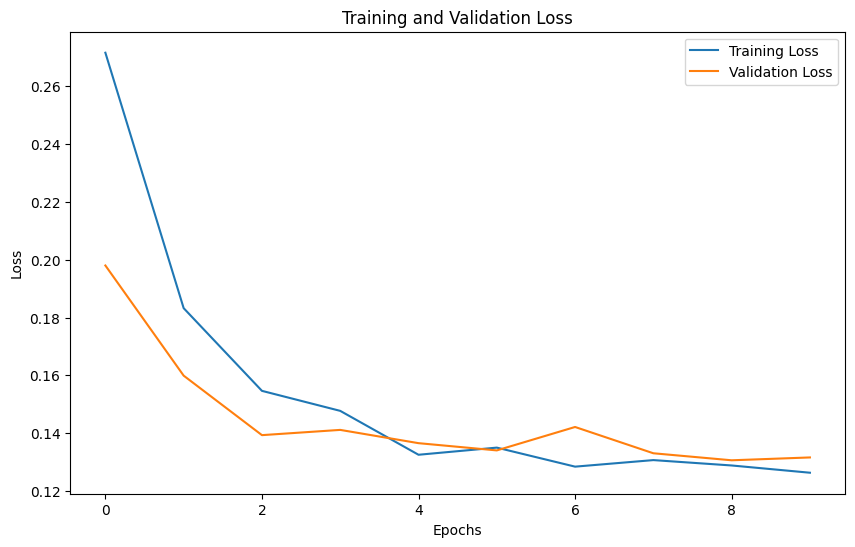

In [36]:
# Step 8: Plot the Losses
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()